In [26]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [27]:
import hopsworks
import pandas as pd

In [28]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/185495
Connected. Call `.close()` to terminate connection gracefully.


# Read in Data

In [29]:
wine_df = pd.read_csv("winequality.csv")
target = "quality"
wine_df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [30]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [31]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [32]:
# Replace spaces in column names
wine_df.columns = wine_df.columns.str.replace(' ', '_')


### Investigate Number of Missing Values per Column

In [33]:
wine_df.isna().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [34]:
# Fill missing data with either random data or a category corresponding to "Unknown"
for column in wine_df.columns:
    if wine_df[column].isna().any() and pd.api.types.is_numeric_dtype(wine_df[column]):
        wine_df.loc[wine_df[column].isna(), column] = [i for i in np.random.choice(range(round(wine_df[column].min()), round(wine_df[column]. max())), wine_df[column].isna().sum())]
    elif wine_df[column].isna().any() and (pd.api.types.is_object_dtype(wine_df[column]) or pd.api.types.is_categorical_dtype(wine_df[column])):
        wine_df[column].fillna("Unknown")


In [35]:
# Check that there are no more missing values
wine_df.isna().sum()

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Checking for and Removing Duplicated Rows

In [36]:
# Check for duplicates and drop duplicates
duplicates = wine_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")
wine_df[wine_df.duplicated()]

Number of duplicates: 1168


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
4,white,7.2,0.230,0.32,8.50,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
5,white,8.1,0.280,0.40,6.90,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
7,white,7.0,0.270,0.36,20.70,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
8,white,6.3,0.300,0.34,1.60,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
39,white,7.3,0.240,0.39,17.95,0.057,45.0,149.0,0.99990,3.21,0.36,8.6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6461,red,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
6462,red,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
6465,red,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
6479,red,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


In [37]:
wine_df.drop_duplicates(inplace=True)
wine_df.reset_index(drop=True, inplace=True)
wine_df.shape

(5329, 13)

### Transform categorical variables into numerical variables

In [38]:
for column in wine_df.columns:
    if pd.api.types.is_categorical_dtype(wine_df[column]) or pd.api.types.is_object_dtype(wine_df[column]):
        one_hot = pd.get_dummies(wine_df[column], prefix=column)
        wine_df = wine_df.drop(column, axis = 1)
        wine_df = wine_df.join(one_hot)

wine_df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
count,5329.000000,5329.00000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000
mean,7.221233,0.34417,0.318746,5.066954,0.056647,30.060143,114.189341,0.994536,3.224055,0.533243,10.548539,5.796022,0.255020,0.744980
std,1.332378,0.16915,0.147500,4.573662,0.036854,17.815588,56.781422,0.002966,0.160405,0.150296,1.186134,0.879922,0.435913,0.435913
min,3.800000,0.00000,0.000000,0.600000,0.000000,1.000000,6.000000,0.987110,2.720000,0.000000,8.000000,3.000000,0.000000,0.000000
25%,6.400000,0.23000,0.240000,1.800000,0.038000,16.000000,75.000000,0.992200,3.110000,0.430000,9.500000,5.000000,0.000000,0.000000
50%,7.000000,0.30000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994640,3.210000,0.510000,10.400000,6.000000,0.000000,1.000000
75%,7.700000,0.41000,0.400000,7.500000,0.066000,41.000000,154.000000,0.996770,3.330000,0.600000,11.400000,6.000000,1.000000,1.000000
max,15.900000,1.58000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000,1.000000


In [39]:
# type_red = 1... red wine, type_red = 0 ... white wine
wine_df["type_red"].value_counts()

0    3970
1    1359
Name: type_red, dtype: int64

### Binning and relabelling target values

In [40]:
wine_df["quality"].value_counts()

6    2327
5    1755
7     857
4     206
8     149
3      30
9       5
Name: quality, dtype: int64

In [41]:
# Initially, target values range from 3 to 9; we bin them into 5 categories and relabel them from 0 to 4
# 0-3: Very Bad (0) = 1 stars, 4: Bad (1) = 2 stars, 5: Mediocre (2) = 3 stars, 6-7: Good (3) = 4 stars, 8-10: Very Good (4) = 5 stars
wine_df['quality'] = [0 if x < 4  else 1 if x==4 else 2 if x==5 else 3 if x <8  else 4 for x in wine_df['quality']]

In [42]:
wine_df["quality"].value_counts()

3    3184
2    1755
1     206
4     154
0      30
Name: quality, dtype: int64

### Investigate predictive power of columns

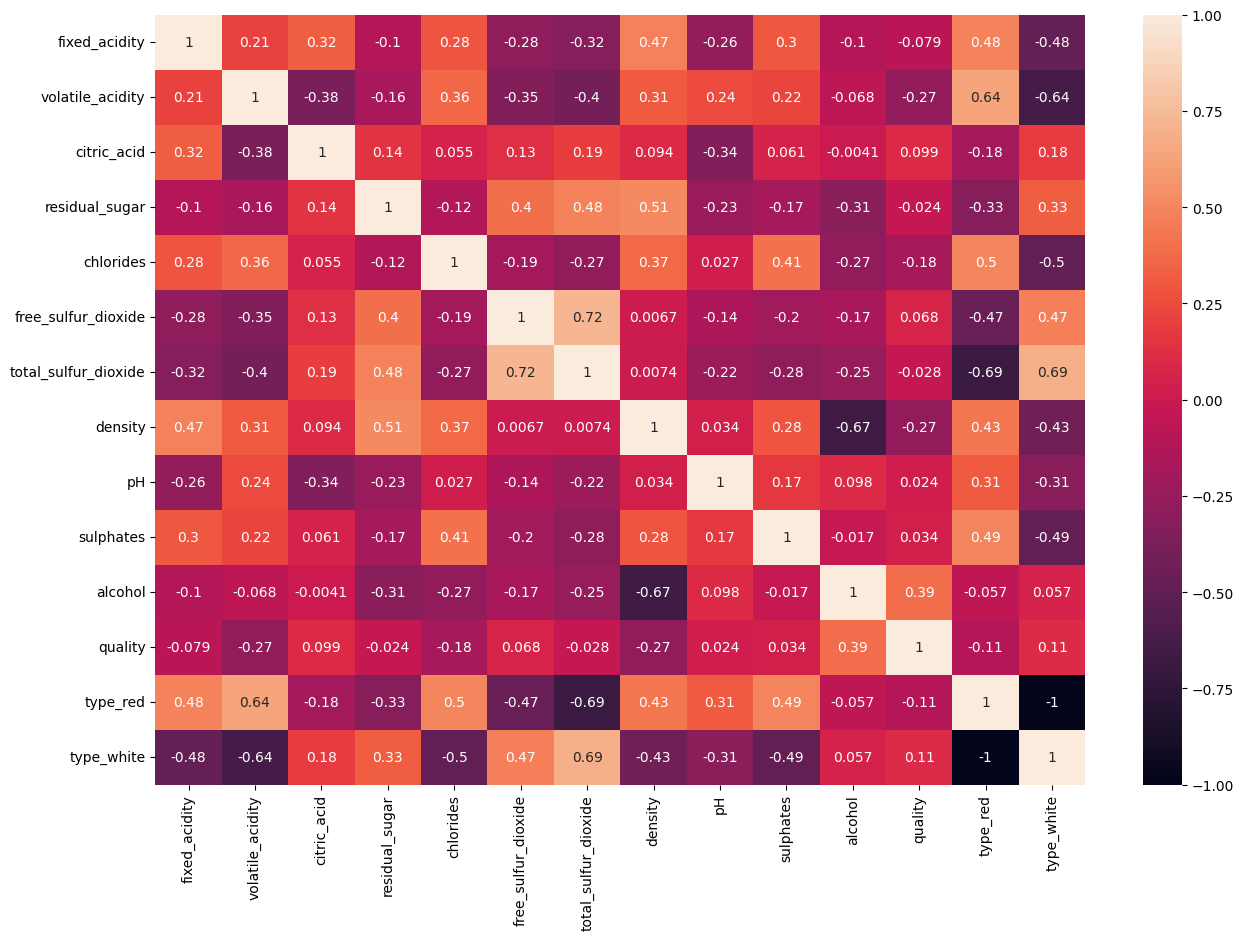

In [43]:
# Exploring Correlation
plt.figure(figsize=(15,10))
cor = wine_df.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [44]:
# Get correlations within the features
features = wine_df.loc[:, wine_df.columns != 'quality']
cor = abs(features.corr())

# Get only upper half of the symmetric correlation matrix
feature_cor_upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
display(feature_cor_upper)

# Exclude features with a correlation coefficient that is higher than 0.7 to at least one other feature
features_to_exclude = [column for column in feature_cor_upper.columns if any(feature_cor_upper[column] > 0.7)]
print(f"features to exclude{features_to_exclude}")

# Find features to be kept
features_to_be_kept = [feature for feature in wine_df.columns if feature not in features_to_exclude]
print(f"features to be kept {features_to_be_kept}")

# Drop features: drop all features that show a low correlation with the target variable and that are highly intercorrelated
for column in wine_df.columns:
    if column not in features_to_be_kept:
        wine_df.drop(column, axis=1, inplace=True)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_red,type_white
fixed_acidity,NaN,0.213061,0.324063,0.102769,0.283504,0.277166,0.321377,0.471586,0.264984,0.297184,0.101994,0.478184,0.478184
volatile_acidity,NaN,NaN,0.378345,0.164514,0.364374,0.346912,0.398634,0.305617,0.244308,0.222538,0.067612,0.639350,0.639350
citric_acid,NaN,NaN,NaN,0.142913,0.055217,0.131788,0.192696,0.094393,0.340906,0.061033,0.004065,0.181205,0.181205
residual_sugar,NaN,NaN,NaN,NaN,0.122696,0.396148,0.481185,0.512887,0.227101,0.172075,0.305011,0.325411,0.325411
chlorides,NaN,NaN,NaN,NaN,NaN,0.186751,0.270033,0.371341,0.027168,0.405064,0.269107,0.499757,0.499757
free_sulfur_dioxide,NaN,NaN,NaN,NaN,NaN,NaN,0.720666,0.006687,0.141074,0.198113,0.170396,0.465295,0.465295
total_sulfur_dioxide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007359,0.221860,0.275818,0.249597,0.694181,0.694181
density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034156,0.281635,0.668216,0.428757,0.428757
pH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166570,0.097611,0.309999,0.309999
sulphates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016556,0.490083,0.490083


features to exclude['total_sulfur_dioxide', 'type_white']
features to be kept ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'type_red']


In [45]:
wine_df.shape

(5329, 12)

## Use SMOTE to expand data

In [46]:
## SMOTE ##
from imblearn.over_sampling import SMOTE

X = wine_df.drop("quality", axis=1)
y = wine_df["quality"]

minority_class_size = y.value_counts().min()
n_neighbors = min(minority_class_size - 1, 5)
smote = SMOTE(k_neighbors=n_neighbors)

# Resample training data
X_resampled, y_resampled = smote.fit_resample(X, y)

wine_df = pd.DataFrame(X_resampled, columns=wine_df.columns)
wine_df['quality'] = y_resampled

## Adjust data after SMOTE to be closer to original class distribution

In [47]:
# Define a function to randomly drop samples from a specified class
def drop_samples(dataframe, class_label, num_samples_to_drop):
    # Filter the class
    class_df = dataframe[dataframe['quality'] == class_label]
    
    # Randomly select samples to drop
    drop_indices = np.random.choice(class_df.index, num_samples_to_drop, replace=False)
    
    # Drop the samples
    return dataframe.drop(drop_indices)

wine_df = drop_samples(wine_df, class_label=2, num_samples_to_drop=500)
wine_df = drop_samples(wine_df, class_label=1, num_samples_to_drop=1000)
wine_df = drop_samples(wine_df, class_label=4, num_samples_to_drop=1500)
wine_df = drop_samples(wine_df, class_label=0, num_samples_to_drop=2000)

In [48]:
wine_df.shape

(10920, 12)

In [49]:
wine_df["quality"].value_counts()

3    3184
2    2684
1    2184
4    1684
0    1184
Name: quality, dtype: int64

## Visualization and Exploration of Final Feature Selection



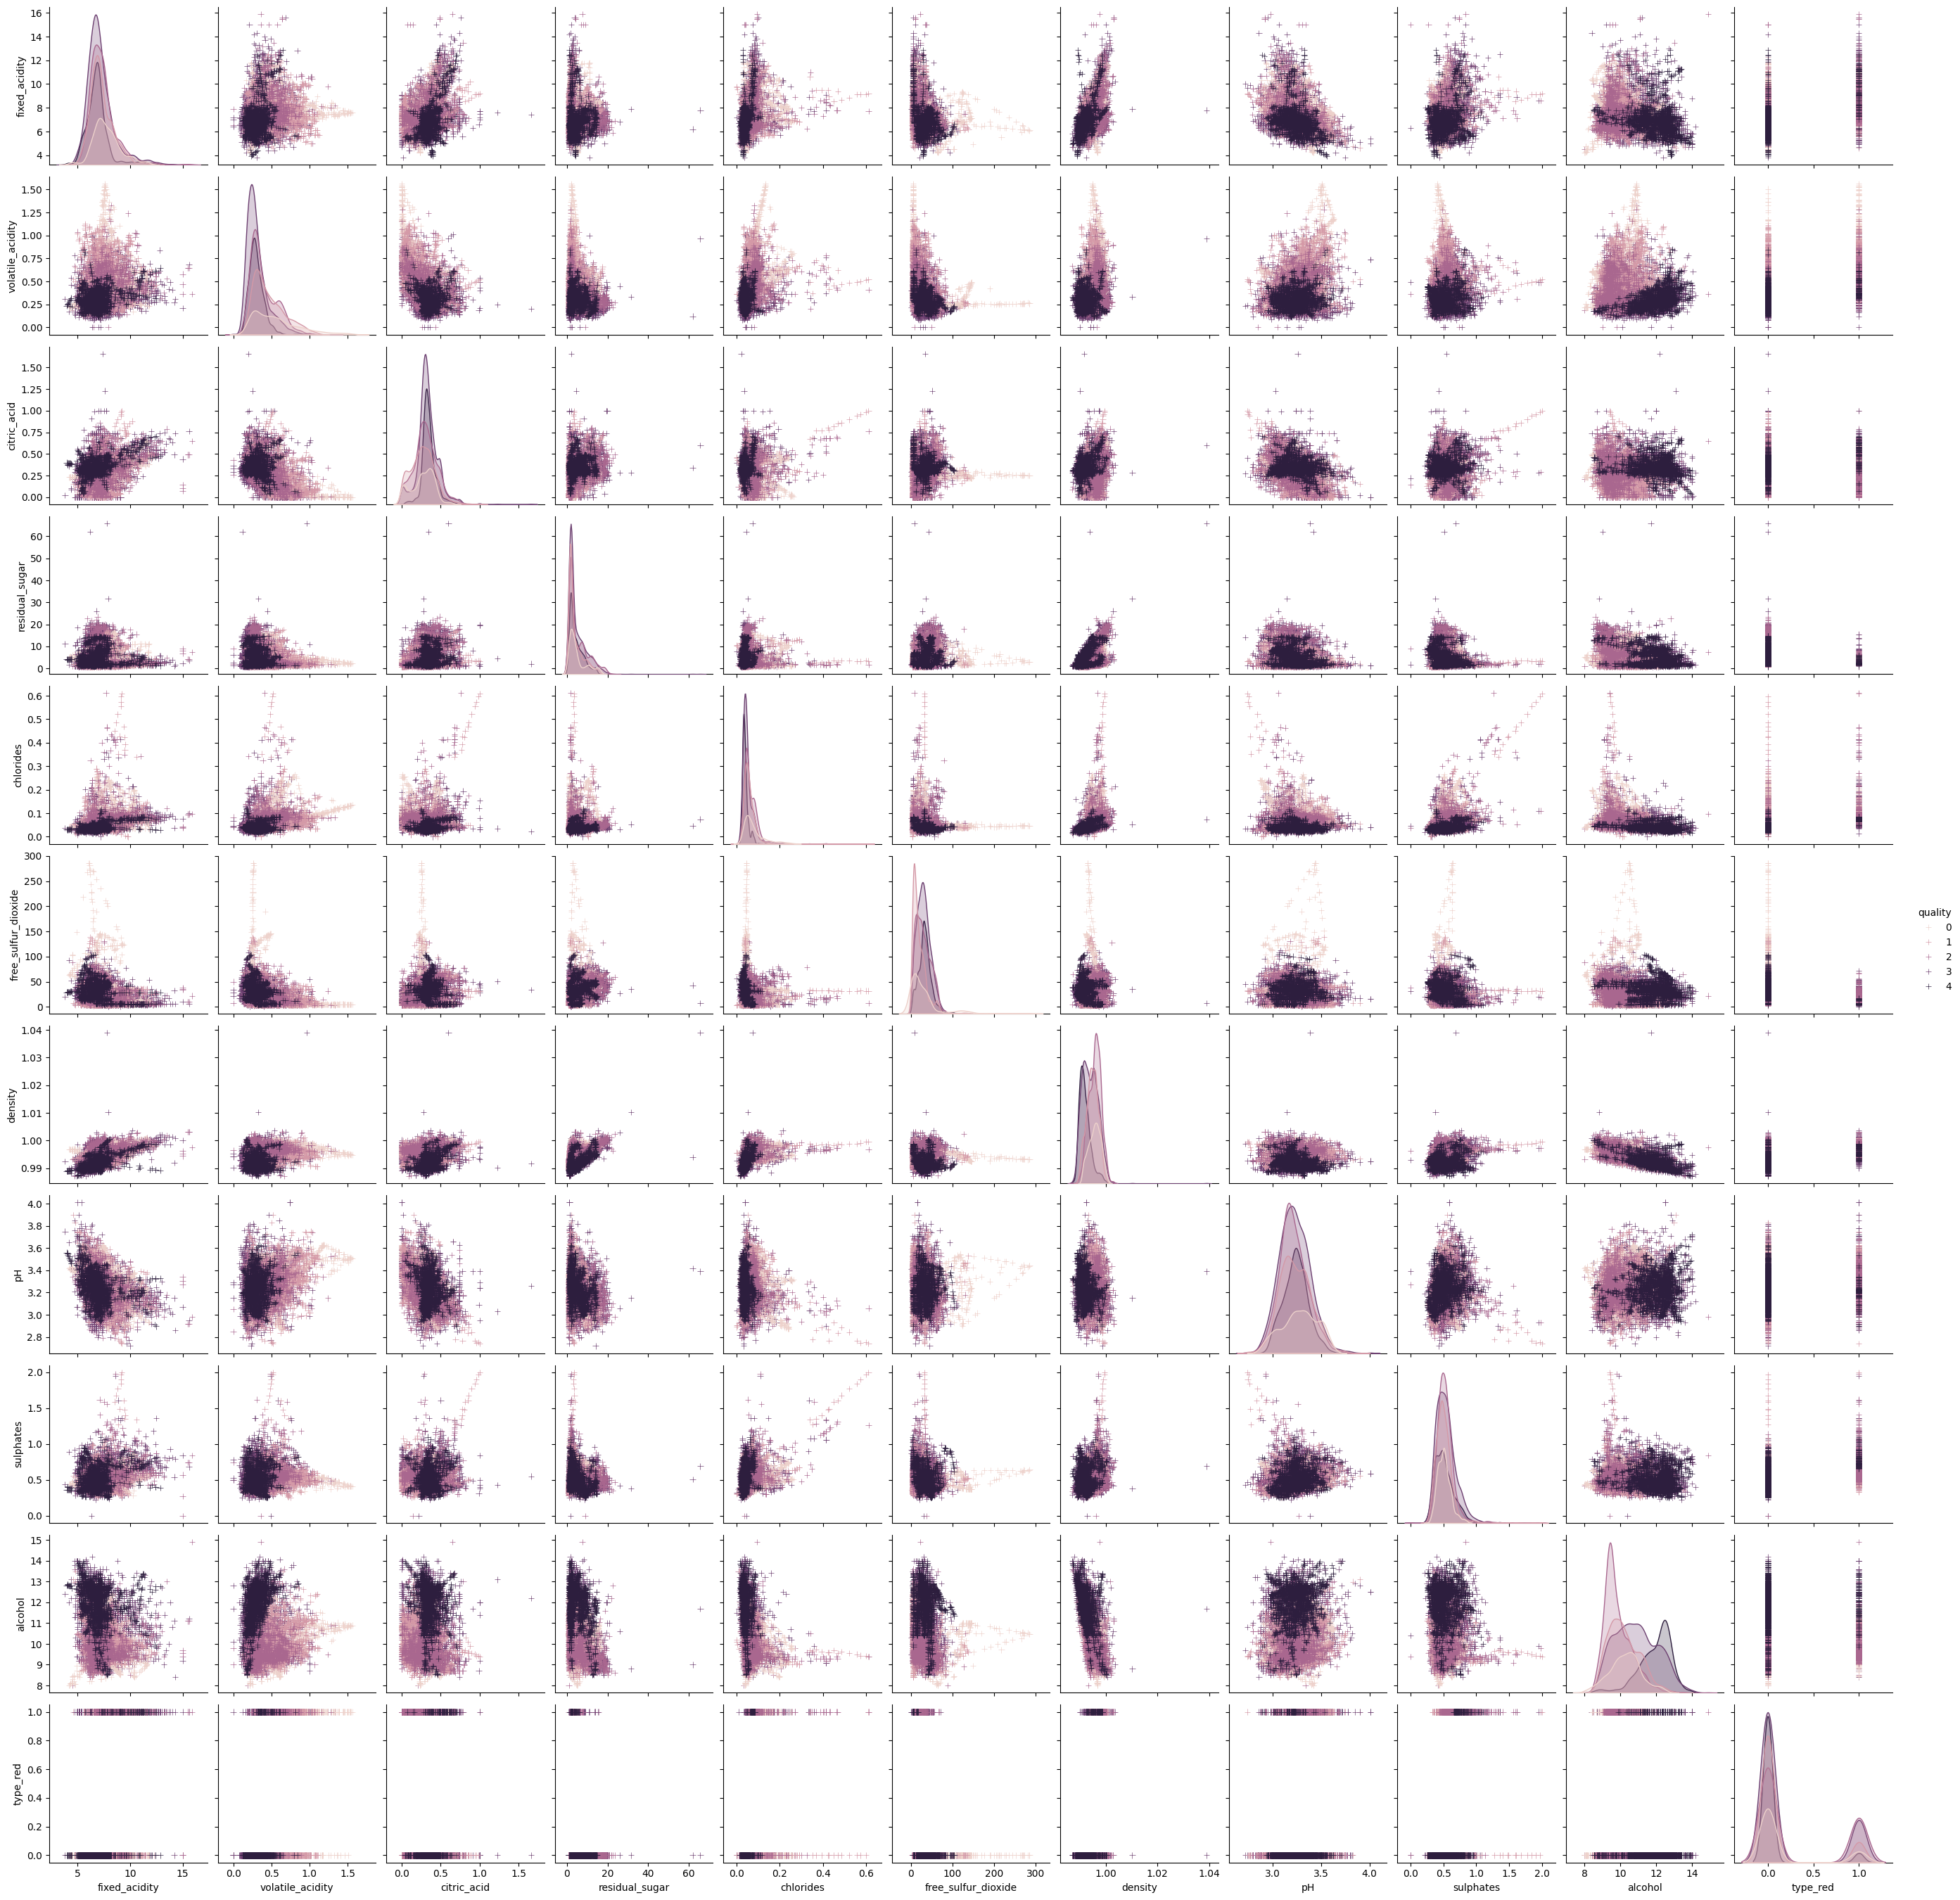

In [50]:
g = sns.pairplot(wine_df, hue='quality', markers='+')
plt.show()

2023-11-14 17:38:34,361 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:34,386 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


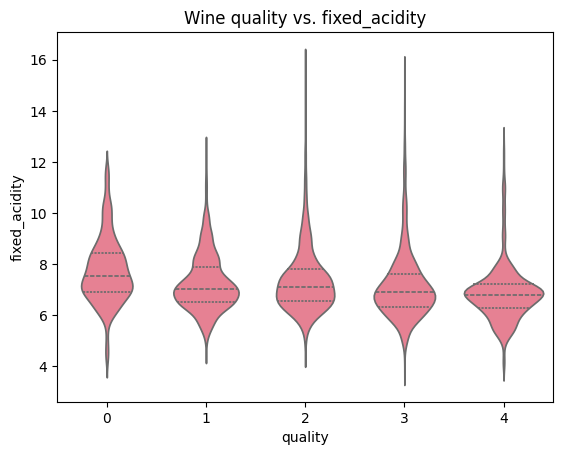

2023-11-14 17:38:34,728 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:34,742 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


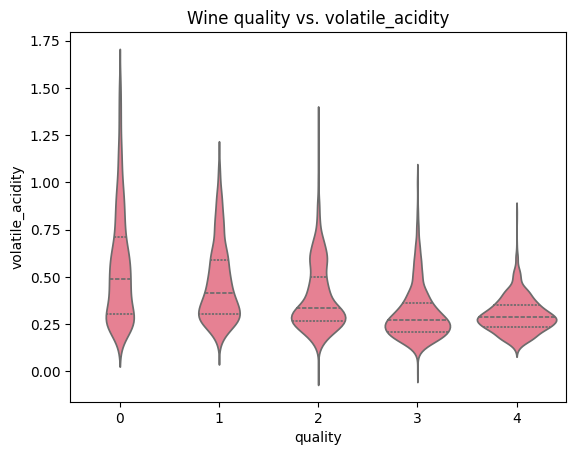

2023-11-14 17:38:35,070 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:35,085 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


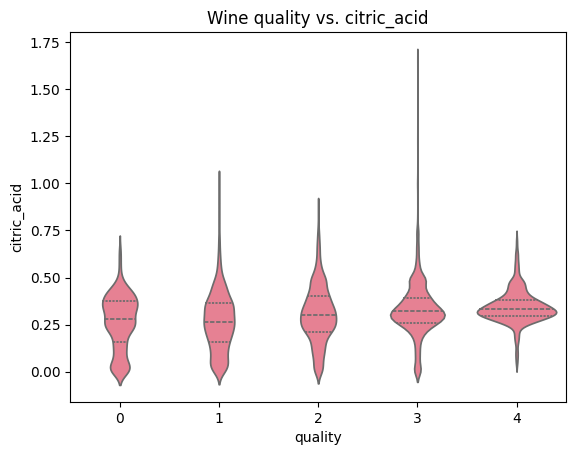

2023-11-14 17:38:35,407 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:35,421 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


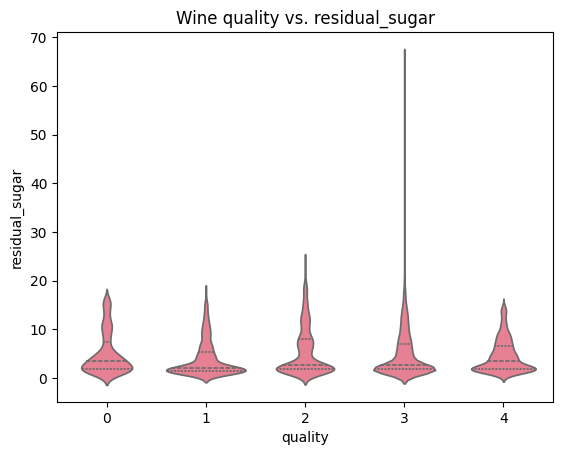

2023-11-14 17:38:35,747 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:35,759 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


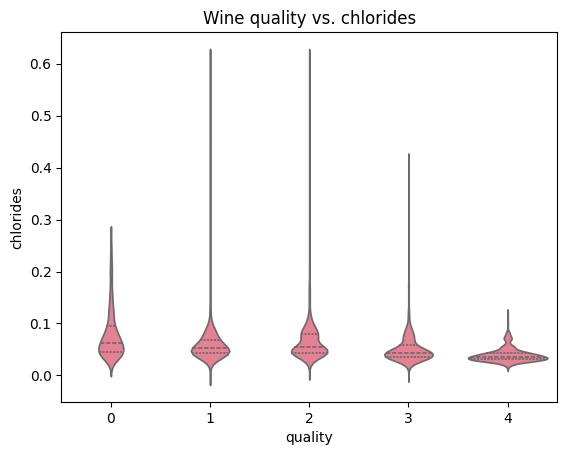

2023-11-14 17:38:36,074 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:36,088 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


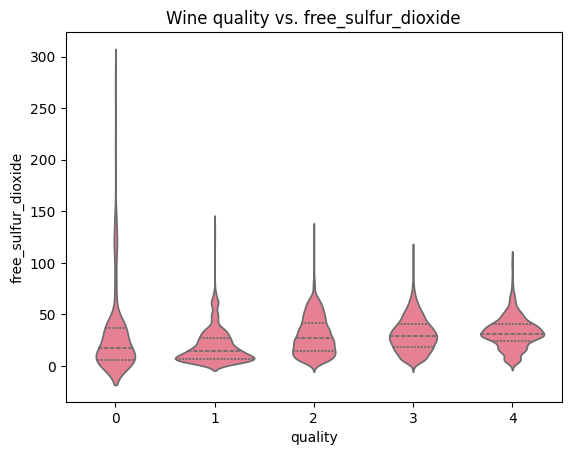

2023-11-14 17:38:36,397 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:36,411 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


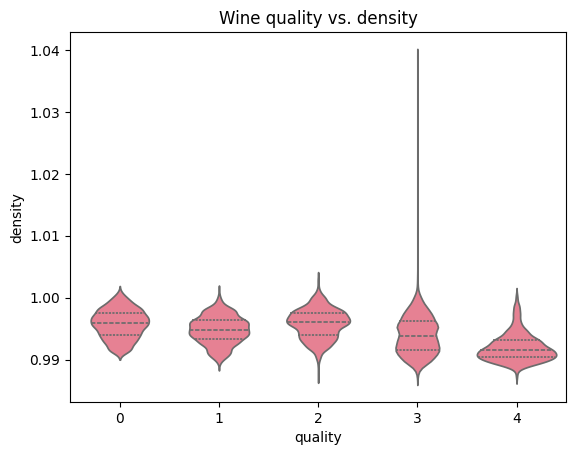

2023-11-14 17:38:36,721 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:36,736 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


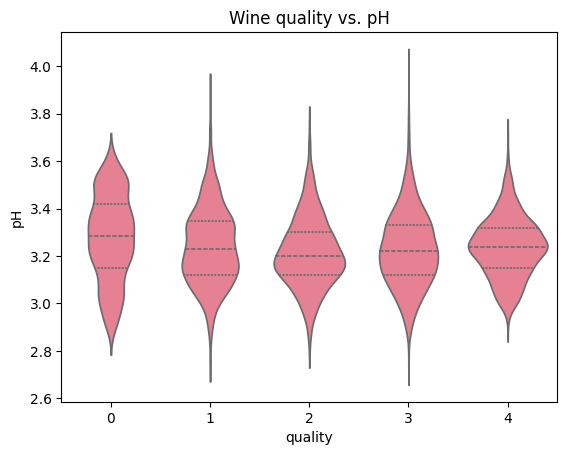

2023-11-14 17:38:37,137 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:37,151 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


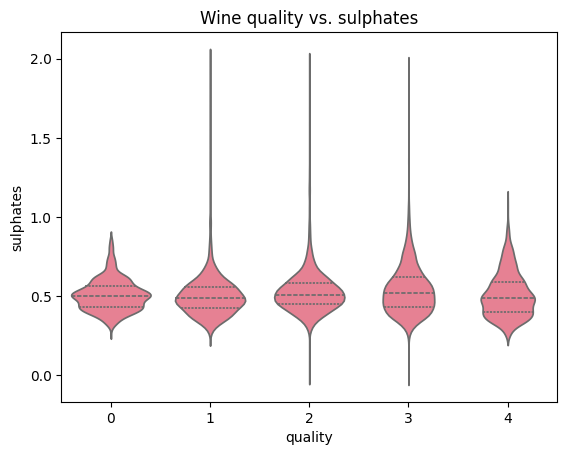

2023-11-14 17:38:37,465 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:37,478 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


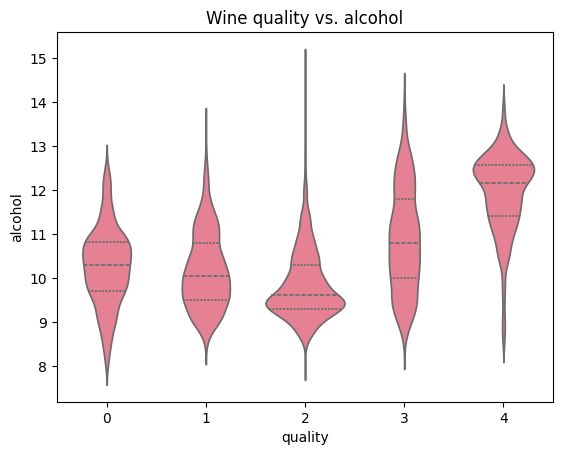

2023-11-14 17:38:37,802 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-11-14 17:38:37,815 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


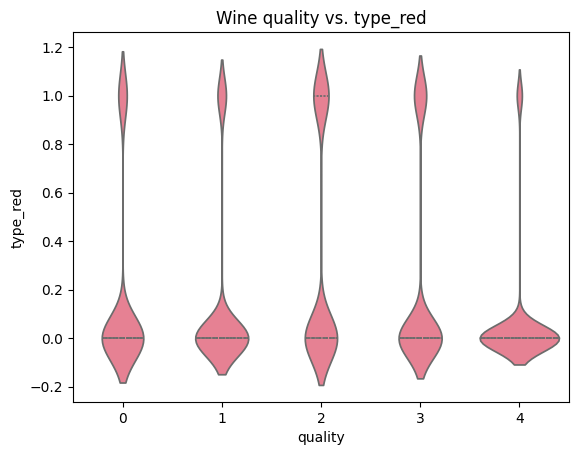

In [51]:
for column in wine_df.loc[:, wine_df.columns != target]:
    g = sns.violinplot(x=target, y=column, data=wine_df, inner='quartile')
    plt.title(f"Wine quality vs. {column}")
    plt.show()


#fig = plt.figure(figsize=(18,6))
#plt.subplot2grid((2,3),(0,0))
#sns.violinplot(x='quality', y='density', data=wine_df)
#plt.title("Wine quality vs density");

#plt.subplot2grid((2,3),(0,1))
#sns.violinplot(x='quality', y='alcohol', data=wine_df)
#plt.title("Wine quality vs alcohol")

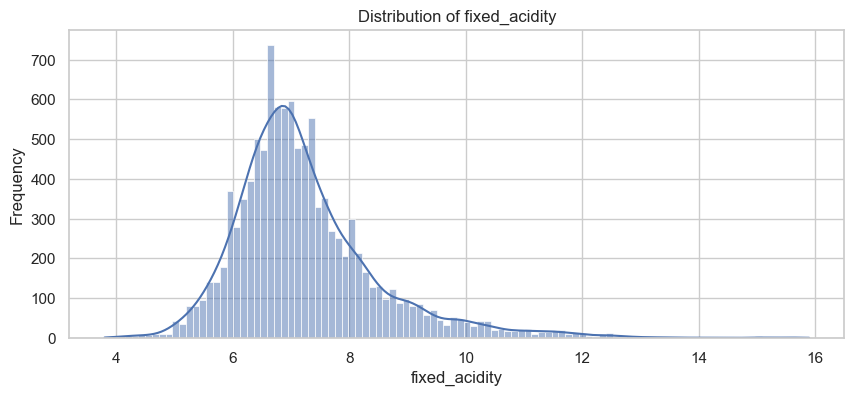

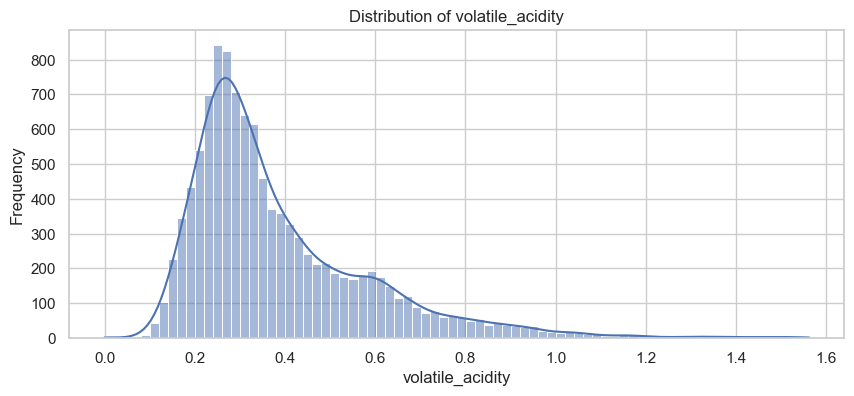

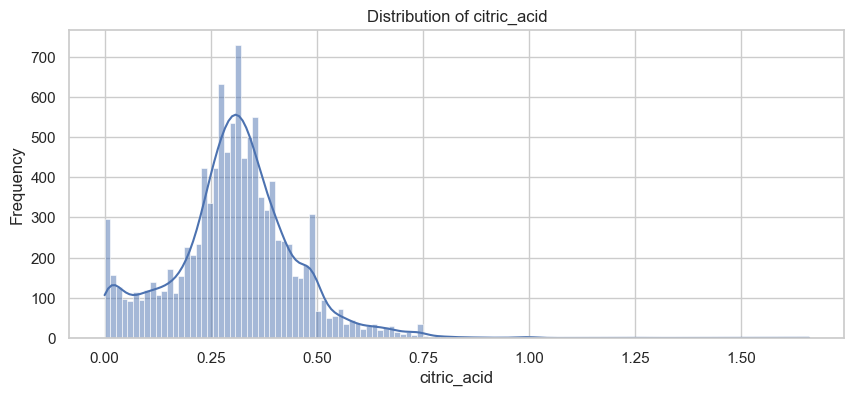

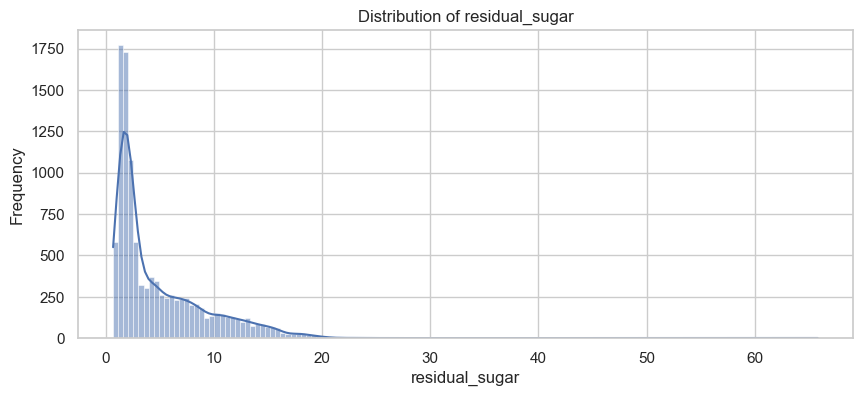

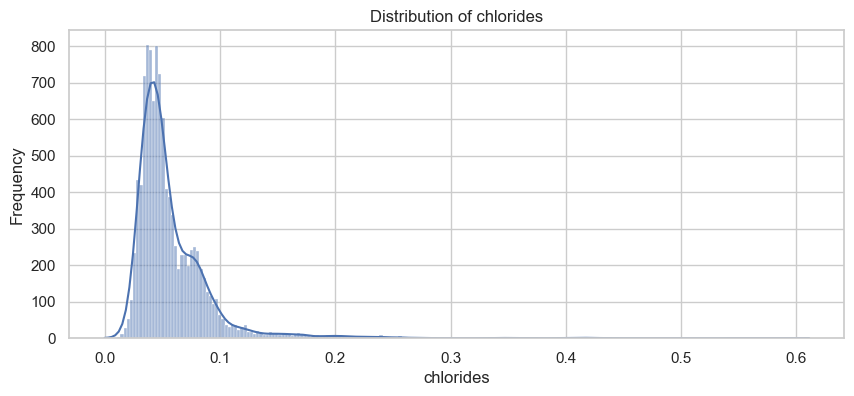

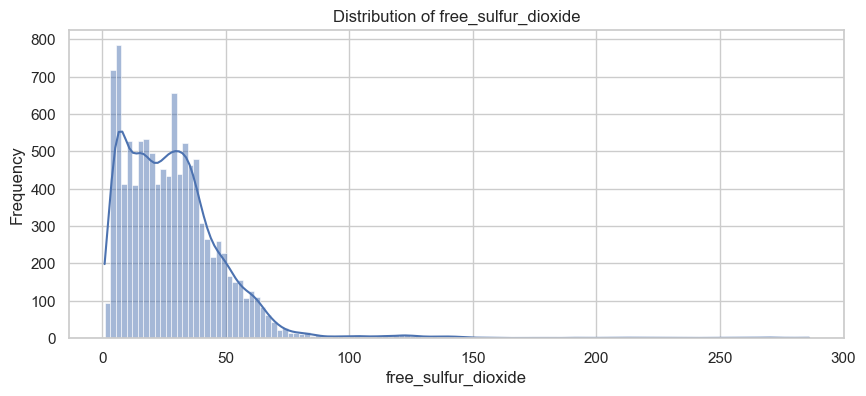

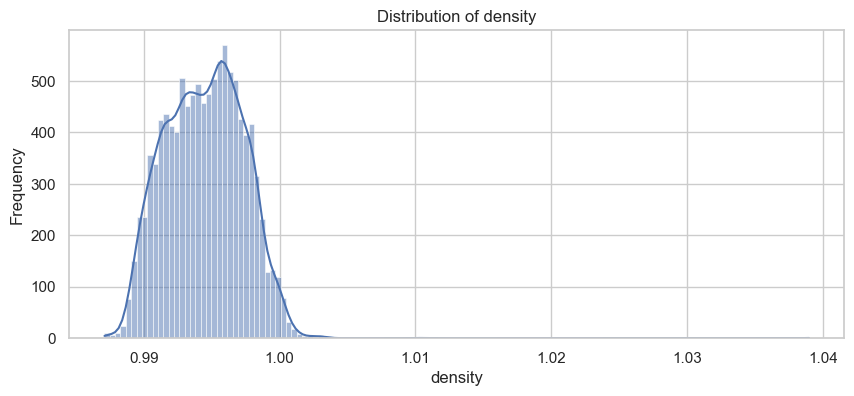

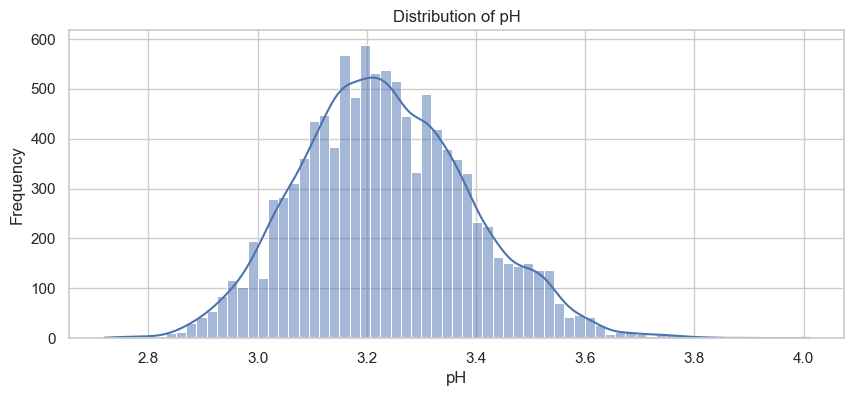

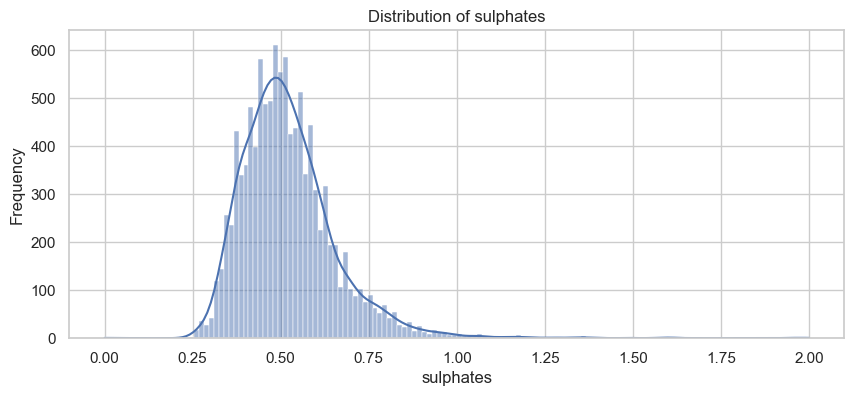

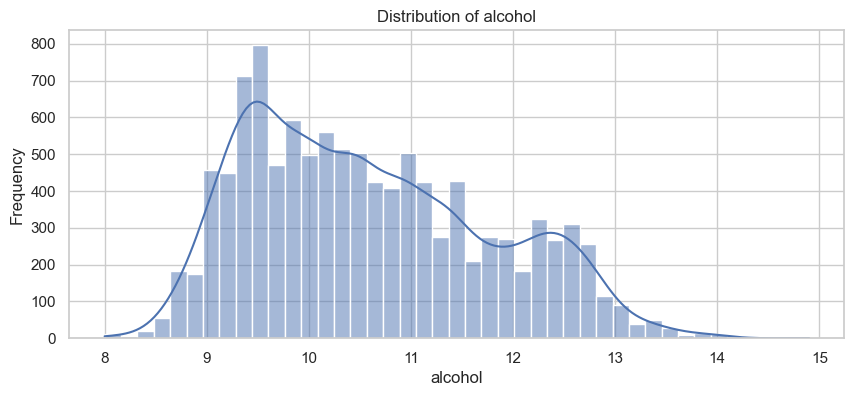

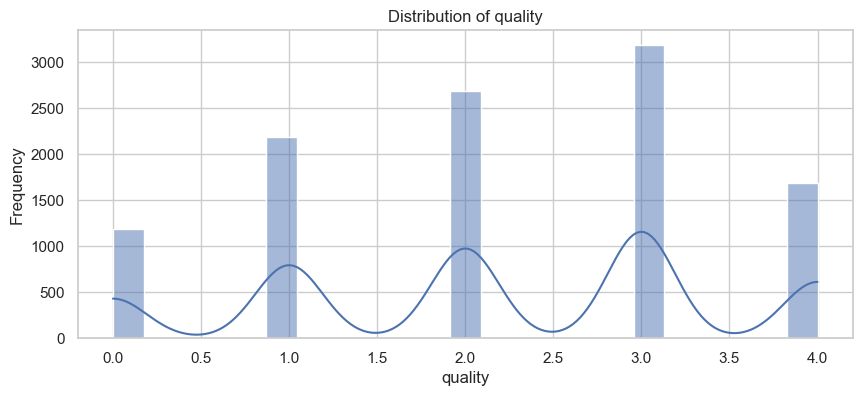

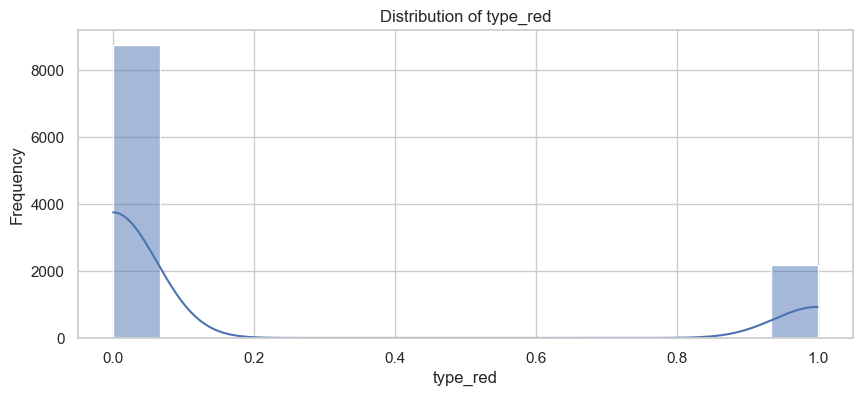

In [52]:
# Display distribution of each feature

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Iterate over each column to create a separate plot
for column in wine_df.columns:
    plt.figure(figsize=(10, 4))  # Adjust the size of the plot
    sns.histplot(wine_df[column], kde=True)  # Histogram with density plot (KDE)

    plt.title(f'Distribution of {column}')  # Set title
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Frequency')  # Set y-axis label
    plt.show()

### Insert Wine Quality DataFrame into a FeatureGroup

In [53]:
wine_fg = fs.get_or_create_feature_group(
    name="wine_enriched_balanced",
    version=1,
    primary_key=['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type_red'],
    description="Wine quality dataset")
wine_fg.insert(wine_df)


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/185495/fs/185414/fg/221553


Uploading Dataframe: 100.00% |██████████| Rows 10920/10920 | Elapsed Time: 00:05 | Remaining Time: 00:00


Launching job: wine_enriched_balanced_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/185495/jobs/named/wine_enriched_balanced_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fee5c911ee0>, None)

### Data Validation

In [54]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column,
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [55]:
#TODO

"""
suite = ExpectationSuite(expectation_suite_name="iris_dimensions")

expect(suite, "sepal_length", 4.5, 8.0)
expect(suite, "sepal_width", 2.1, 4.5)
expect(suite, "petal_length", 1.2, 7)
expect(suite, "petal_width", 0.2, 2.5)
iris_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")

"""

'\nsuite = ExpectationSuite(expectation_suite_name="iris_dimensions")\n\nexpect(suite, "sepal_length", 4.5, 8.0)\nexpect(suite, "sepal_width", 2.1, 4.5)\nexpect(suite, "petal_length", 1.2, 7)\nexpect(suite, "petal_width", 0.2, 2.5)\niris_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")\n\n'